In [1]:
import mediapipe_helper as mph

## **1. 한 사람이 등장하는 애니메이션 gif 파일 준비**

image: https://news.yahoo.com/gif-guide-figure-skaters-39-jumps-olympics-171900531.html

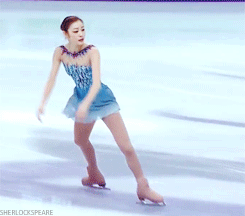

In [2]:
# import ipywidgets as widgets
from IPython.display import Image


fileName = './demo/figure.gif'

with open(fileName,'rb') as f:
    display(Image(data=f.read(), format='gif', width= 500))

## **2. mediapipe의 도움으로 애니메이션 gif 파일에서 관절 좌표 검출**

![](https://camo.githubusercontent.com/54bca34365633c5a5a81be9ac7ff6c6e6198731b73faa61b446b9f51dfe29484/68747470733a2f2f676f6f676c652e6769746875622e696f2f6d65646961706970652f696d616765732f6d6f62696c652f706f73655f747261636b696e675f66756c6c5f626f64795f6c616e646d61726b732e706e67)

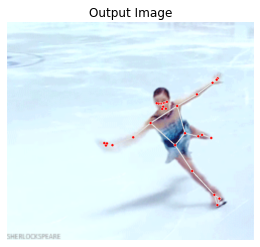

In [3]:
mediapipe_json_object = mph.gif_to_mediapipe_json2(fileName=fileName, maxFrameNum=100, modelComplexity=2, display= True)

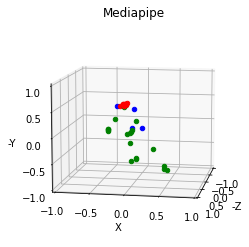

{'x': 0.08301414549350739, 'y': -0.01397886872291565, 'z': -0.005738214589655399, 'score': 0.9999436140060425, 'name': 'left_hip'}
{'x': -0.08088468015193939, 'y': 0.010377438738942146, 'z': 0.007137633394449949, 'score': 0.9998778104782104, 'name': 'right_hip'}


In [4]:
mph.draw_mediapipe(mediapipe_json_object,0,0)
name_idx  =mph.get_name_idx_map()
print(mediapipe_json_object["frames"][0]["keypoints3D"][name_idx["left_hip"]])
print(mediapipe_json_object["frames"][0]["keypoints3D"][name_idx["right_hip"]])
# mp_gif_path = mph.json_to_gif(json_object=mediapipe_json_object,
#             save_path='./demo', is_axes_move= True)
# print(mp_gif_path)

# with open(mp_gif_path,'rb') as f:
#     display(Image(data=f.read(), format='gif'))

## **3. Mediapipe에서 검출한 관절 데이터를 Mixamo 모델의 뼈대와 매핑**

![](https://help.autodesk.com/cloudhelp/2018/ENU/Maya-CharacterAnimation/images/GUID-4F9DB7C0-7325-4A14-B351-934B7EFDB086.png)

- Mixamo 모델 사용 이유
    - 모델 데이터와 애니메이션 데이터를 자유롭게 사용 가능 (데이터 그 자체를 판매하는것을 제외하고)
    - 스켈레톤이 없는 모델을 mixamo 스켈레톤 구조를 가지게 리깅해주는 서비스를 제공함


- mediapipe가 검출하지 않은 관절 부분은 평균값을 사용함
    - `Hips`: left_hip과 right_hip의 평균
    - `Head`: left_ear, right_ear 의 평균
    - `Neck`: left_shoulder, right_shoulder의 평균
    - `Spine2`: Hips 와 Neck 의 평균
    - `Spine`:  Spine2와 Hips의 평균
    - `Spine3`: Spine2 와 Neck 의 평균

In [5]:
import mixamo_helper as mmh

In [6]:
mixamo_json_object = mmh.mediapipeToMixamo(
                            mph.get_name_idx_map(), 
                            mediapipe_json_object)

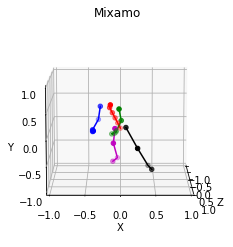

{'x': 0.0,
 'y': 0.0,
 'z': 0.0,
 'score': 0.9999107122421265,
 'name': 'Hips',
 'parent': -1}

In [7]:
mmh.draw_mixamo(mixamo_json_object, 0, 0)
mixamo_json_object["frames"][0]["keypoints3D"][0]

### **결과 이미지**
|mediapipe|mixmao|
|-|-|
|![](./demo/figure.gif_json_mp_round_.gif)|![](./demo/figure.gif_json_mm_round_.gif)|

## 4. **검출한 좌표값과 모델의 바인딩포즈 좌표값과의 상대적인 각도 변환 계산**


### **4.1 모델의 바인딩 포즈데이터를 로드하는 이유**

|amy 모델|vampire 모델|cyborg 모델|
|-|-|-|
|![](./screenshot/amy_binding_360.gif)|![](./screenshot/zom_binding_360.gif)|![](./screenshot/cyb_binding_360.gif)|

- 동일한 스켈레톤 계층 구조를 가져도, 모델의 바인딩포즈는 서로 다른 경우가 많음
- 애니메이션 데이터는 이 바인딩 포즈에 상대적인 각도이므로
- 다양한 모델에 대응하기 위해서 모델의 바인딩포즈 데이터를 로드해야함
- 바인딩 포즈 데이터는 pixel3d 에서 내보내기할 수 있음

In [ ]:
import json

model_binding_pose_file = './pixel3d_json/zom_model.json'
pixel3d_json_object = None
with open(model_binding_pose_file) as f:
    pixel3d_json_object = json.load(f)

### **4.2 간단한 역기구학 풀이로 각도변환 계산**

![](./demo/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7%202022-05-18%20%EC%98%A4%ED%9B%84%2010.04.34.png)

- T에서 G로 이동하기위한 각도 계산

    1. 좌표계 원점에서 T를 향하는 단위 벡터 v1, G를 향하는 단위 벡터 v2를 구함
    2. 내적을 응용하여 v1과 v2와의 각도 φ를 계산
    3. v1과 v2를 외적을 통해 회전의 기준점이될 회전축을 계산
    4. 구한 회전축을 기준으로 φ 도 회전하면 G 로 이동됨

    ```python
       return glm.rotate(glm.mat4(1.0),
                          glm.acos(glm.dot(v1, v2)),
                          glm.cross(v1, v2))
    ```
- 여기서 T는 바인딩포즈 좌표, G는 검출한 관절 좌표값

In [8]:
import pyglm_helper as glmh


anim_json = glmh.get_anim_json2(mixamo_json_object, pixel3d_json_object)

In [9]:
anim_json

{'fileName': './demo/figure.gif',
 'duration': 39,
 'ticksPerSecond': 10,
 'frames': [{'time': 0,
   'bones': [{'name': 'Hips',
     'rotation': {'w': 0.9764214158058167,
      'x': 0.19626019895076752,
      'y': -0.01708214357495308,
      'z': 0.08826836943626404},
     'position': {'x': 0.0, 'y': 0.0, 'z': 0.0},
     'scale': {'x': 1.0, 'y': 1.0, 'z': 1.0}},
    {'name': 'Spine',
     'rotation': {'w': 0.9962005615234375,
      'x': -0.009395632892847061,
      'y': 0.009355811402201653,
      'z': 0.0860731303691864},
     'position': {'x': 0.0, 'y': 0.0, 'z': 0.0},
     'scale': {'x': 1.0, 'y': 1.0, 'z': 1.0}},
    {'name': 'Spine1',
     'rotation': {'w': 0.9951832890510559,
      'x': -0.05795913189649582,
      'y': 0.0005171126103959978,
      'z': 0.07906105369329453},
     'position': {'x': 0.0, 'y': 0.0, 'z': 0.0},
     'scale': {'x': 0.9999999403953552, 'y': 1.0, 'z': 1.0}},
    {'name': 'Spine2',
     'rotation': {'w': 0.9310325980186462,
      'x': -0.33869513869285583,

In [10]:
import ntpath
with open('./demo/figure_anim_file_('+ ntpath.basename(model_binding_pose_file)+').json', 'w') as f:
    j_string = json.dump(anim_json, f, indent= 2)

### **결과 이미지**

|amy 모델|vampire 모델|cyborg 모델|
|-|-|-|
|![](./demo/amy_figure_glm_round.gif)|![](./demo/zom_figure_glm_round.gif)|![](./demo/cyb_figure_glm_round.gif)|